In [ ]:
import pandas as pd
import geopandas as gpd
import pydeck as pdk
import matplotlib.pyplot as plt
import numpy as np
import folium

# Get a Google Maps API Key [here](https://developers.google.com/maps/documentation/javascript/get-api-key) 

Copy-paste your API Key when prompted when running the cell below.

Only run the following block if you want to view the Arc graph of travels between tracts.

In [ ]:
import os
from getpass import getpass

# Try to read from env first, otherwise prompt you
GOOGLE_MAPS_API_KEY = os.getenv("GOOGLE_MAPS_API_KEY") or getpass("Enter your Google Maps API key: ")

# (Optionally) store it back in os.environ for downstream cells
os.environ["CENSUS_API_KEY"] = GOOGLE_MAPS_API_KEY

print("Key loaded, length:", len(GOOGLE_MAPS_API_KEY), "characters")

In [ ]:
# Read CSV file containing LODES data
od = pd.read_csv("ca_od_main_JT00_2022.csv", dtype={"w_geocode": str, "h_geocode": str})

In [ ]:
# Extract 11-digit tract GEOIDs (tract codes, not full GEOIDs for blocks)
od["h_tract"] = od["h_geocode"].str[:11]
od["w_tract"] = od["w_geocode"].str[:11]

# Choose a data variable to plot
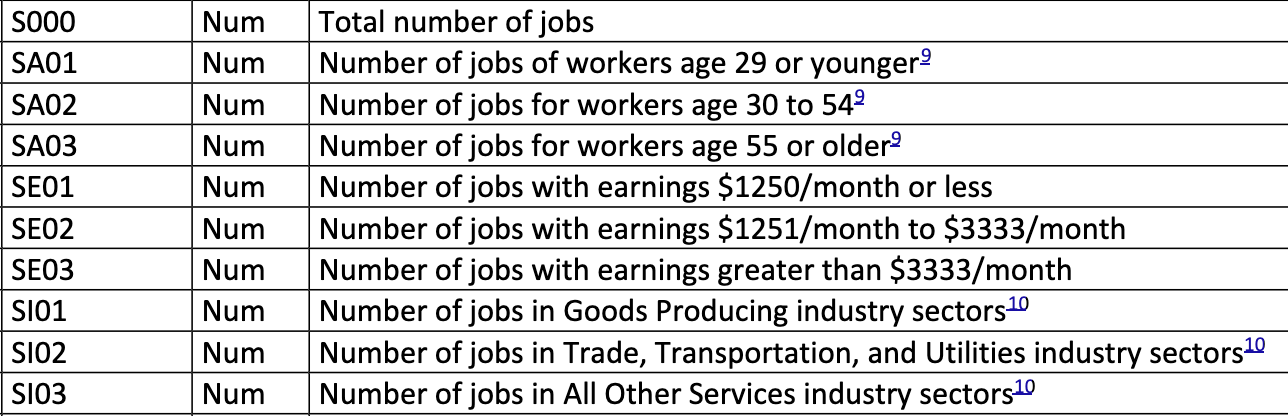

In [ ]:
data_var = "S000"

In [ ]:
# Group by home→work tract pairs and sum jobs in data_var
od_tract = (
    od
    .groupby(["h_tract", "w_tract"], as_index=False)[data_var]
    .sum()
    .rename(columns={data_var: "jobs"})
)

# Also compute total out-flow per origin tract for a choropleth
origin_totals = (
    od_tract
    .groupby("h_tract", as_index=False)["jobs"]
    .sum()
    .rename(columns={"h_tract": "GEOID", "jobs": "total_jobs_out"})
)

In [ ]:
# Read the TIGER/Line shapefile for California tracts, static choropleth
path = "/Users/dsong/Library/CloudStorage/OneDrive-UniversityofIllinois-Urbana/Research/UROP 2025 - UAM/Demand Analysis/TIGER Line 2022 Tract/tl_2022_06_tract.shp"
tracts = gpd.read_file(path)[["GEOID", "geometry"]]

# 3.2. Merge the origin totals onto the GeoDataFrame
gdf_origins = tracts.merge(origin_totals, on="GEOID", how="left").fillna(0)

# 3.3. Filter to Bay-Area tracts by county FIPS
bay_counties = {
    "06001",  # Alameda
    "06013",  # Contra Costa
    "06041",  # Marin
    "06055",  # Napa
    "06075",  # San Francisco
    "06081",  # San Mateo
    "06085",  # Santa Clara
    "06095",  # Solano
    "06097",  # Sonoma
}
# GEOID[:5] is state+county FIPS
gdf_bay = gdf_origins[gdf_origins["GEOID"].str[:5].isin(bay_counties)].copy()

# Static Choropleth

Yellow indicates more people leaving their tract to go somewhere else (more outbound travel beyond their tract)

In [ ]:
fig, ax = plt.subplots(figsize=(8, 8))
gdf_bay.plot(
    column="total_jobs_out",
    cmap="inferno",
    legend=True,
    legend_kwds={
        "label": "Commutes Originating in Tract",
        "fmt": "{:.0f}",
    },
    linewidth=0.1,
    edgecolor="gray",
    ax=ax
)
ax.set_title(f"2022 Annual Commute Origins by Tract {data_var} — Bay Area")
ax.axis("off")
plt.show()

# Dynamic Choropleth

Google Maps overlay, red indicates greater outbound travel outside the tract

In [ ]:
# Define your view over the Bay Area
coords = np.vstack(gdf_bay.geometry.centroid.apply(lambda p: (p.y, p.x)))
view_state = pdk.ViewState(
    latitude=coords[:,0].mean(),
    longitude=coords[:,1].mean(),
    zoom=9,
    pitch=0
)

# 1. Center map on Bay Area
center = [view_state.latitude, view_state.longitude]
m = folium.Map(location=center, zoom_start=9, tiles=None)

# 2. Add Google Streets as your basemap
folium.TileLayer(
    tiles="https://mt1.google.com/vt/lyrs=m&x={x}&y={y}&z={z}",
    attr="Google",
    name="Google Streets",
    control=False
).add_to(m)

# 3. Add the choropleth with legend
folium.Choropleth(
    geo_data=gdf_bay.__geo_interface__,
    data=gdf_bay,
    columns=["GEOID","total_jobs_out"],
    key_on="feature.properties.GEOID",
    fill_color="YlOrBr",         # pick any Matplotlib colormap
    fill_opacity=0.7,
    line_opacity=0.2,
    legend_name=f"Annual Commute Origins {data_var}"
).add_to(m)

# 4. Display
m

In [ ]:
# Compute centroids for each tract
tracts["centroid"] = tracts.geometry.centroid
cen = tracts.set_index("GEOID")["centroid"]

# Attach centroid coords to od_tract
flows = od_tract.copy()
flows["start"] = flows["h_tract"].map(lambda g: [cen[g].x, cen[g].y])
flows["end"]   = flows["w_tract"].map(lambda g: [cen[g].x, cen[g].y])

# Keep only flows where both home AND work tracts are in the Bay Area
flows_bay = flows[
    flows["h_tract"].str[:5].isin(bay_counties) &
    flows["w_tract"].str[:5].isin(bay_counties)
].copy()

# (Re)center your view on the Bay Area arcs
coords = np.array(flows_bay.start.tolist())
view_state = pdk.ViewState(
    latitude=coords[:,1].mean(),
    longitude=coords[:,0].mean(),
    zoom=9,       # tighter zoom if you like
    pitch=30
)

In [ ]:
# 4. Build your ArcLayer on the filtered data
arc_layer = pdk.Layer(
    "ArcLayer",
    data=flows_bay,
    get_source_position="start",
    get_target_position="end",
    get_width="jobs / 50",
    get_source_color=[255, 100, 100, 180],
    get_target_color=[100, 100, 255, 180],
    pickable=True
)

GOOGLE_MAPS_API_KEY = "YOUR_API_KEY"  # Replace
# 5. Render it on a light Google basemap
r = pdk.Deck(
    layers=[arc_layer],
    initial_view_state=view_state,
    map_provider="google_maps",
    api_keys={"google_maps": GOOGLE_MAPS_API_KEY},
    map_style="roadmap",
    tooltip={"text": "{jobs} commuters"}
)
r.show()